# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 26th of november at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [208]:
# Change here using YOUR first and last names
fn1 = "Yu"
ln1 = "Xiang"
fn2 = "Jean"
ln2 = "Babin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_xiang_yu_and_babin_jean.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [209]:
%matplotlib inline

In [210]:
from time import time

import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit
import pandas as pd

In [211]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [212]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [213]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [214]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [215]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [216]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

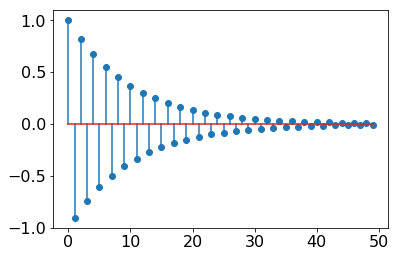

In [217]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [218]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

2.417765767469002e-06

In [219]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

2.437846002006299e-07

### Choice of the model

In [220]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [221]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.06212121943124393


### Get a very precise minimum to compute distances to minimum

In [222]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5248965518000425
1.0110130991027773e-08


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [223]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [224]:
# Number of iterations
n_iter = 200

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the GD solver in the cell below

In [225]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        # in each iteration, all the gradients and x_k are updated
        x = x - grad(x, *args) * step 
      
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list


In [226]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))

monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the AGD solver in the cell below

In [227]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        
        x_new = y - step * grad(y, *args)    
        t_new = (1 + (1 + 4 * t ** 2) ** 0.5) / 2
        y = x_new + (t - 1) * (x_new - x) / t_new      
        x = x_new
        t = t_new

    return x, x_list

In [228]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s nonlinear conjuguate gradient solver. First, define a function to run scipy algorithms and return the list of iterates.

In [229]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [230]:
# Nonlinear Conjugate gradient algorithm
from scipy.optimize import fmin_cg

x_init = np.zeros(d)

monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A, b ,lbda))
monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)

         Current function value: 0.524897
         Iterations: 138
         Function evaluations: 227
         Gradient evaluations: 226


### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [231]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [232]:
colors = ['b', 'g', 'r','m', 'y', 'k', 'c']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']

def plot_epochs(monitors, solvers):
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    nr_m = len(monitors)
    for i in np.arange(nr_m):  
        monit = monitors[i]
        plt.semilogy(monit.obj, lw=2, c= colors[i], linestyle=linestyles[i])
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for i in np.arange(nr_m):  
        monit = monitors[i]
        plt.semilogy(monit.err, lw=2, c= colors[i], linestyle=linestyles[i])
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers):
    plt.figure(figsize=(7, 7))
    nr_m = len(monitors)
    for i in np.arange(nr_m):  
        monit = monitors[i]
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2, 
                     c= colors[i], linestyle=linestyles[i])
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

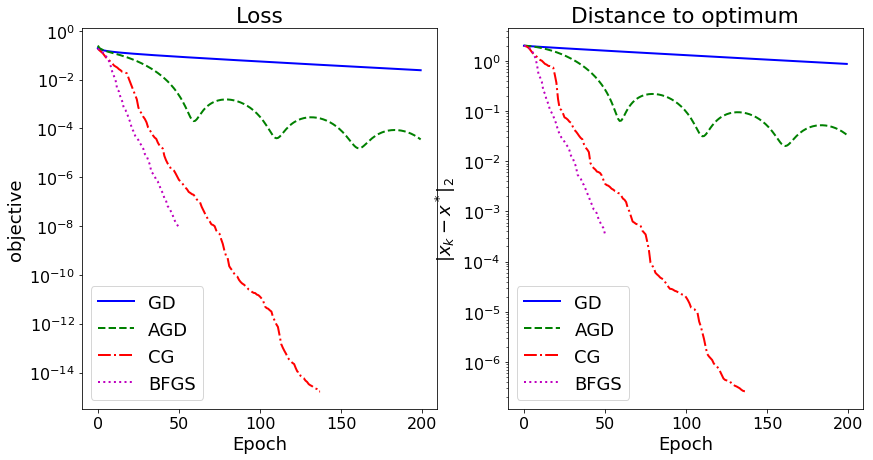

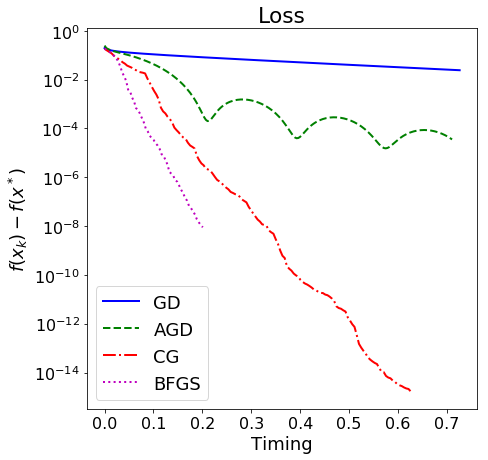

In [233]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs]
solvers = ["GD", "AGD", "CG", "BFGS"]
plot_epochs(monitors, solvers)
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

#### Give some first conclusions about the batch solver studied here
Regarding to the both convergence rate (by the number of iterations) and also the time used (converging to the true values), BFGS perform the best, CG the second, AGD the third and GD the fourth. We see some zigzag effect for AGD method

####  What do you observe about AGD? is it suprising ?

For AGD, the iterates are not monotone. That is, the function values
may increase for a couple of iterates, before decreasing again. 

It is not suprising, as the AGD method can not gurantee the monotonicity becasue the extrapolation term when updating $y_{k+1}$


<a id='stoc'></a> 
## 4. Stochastic methods

In [234]:
# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [235]:
@njit
def sgd(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        
        i = iis[idx]     
        x = x - grad_i(i, x, *args) * step / (idx + 1) ** 0.5
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [236]:
step0 = 1e-1
x_init = np.zeros(d)
monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, n_iter*n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [237]:
@njit
def sag(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))  # n: number of sample size
    averaged_gradient = np.zeros(d)     # d: number of x_i, i.e number of variables
    x_list = []
    
    # initilize the gradient table and average gradient
    for i in np.arange(n):
            gradient_memory[i,:] = grad_i(i, x, *args)        
    sum_gradient = np.sum(gradient_memory, axis=0) 
    
    for idx in range(n_iter):   # idx: iteration index, i.e. time t
        i = iis[idx]            # random chosen sample index at time t
        
        # update the average gradients   
        sum_gradient -= gradient_memory[i,:]    
        
        # only update the gradient of the select i, others remain as the previosu step
        gradient_memory[i,:] = grad_i(i, x, *args)
        sum_gradient  += gradient_memory[i,:]    
        averaged_gradient = sum_gradient / n  
    
        x = x - step * averaged_gradient
       
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [238]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, n_iter*n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [239]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    
    for idx in range(n_iter):  # corresponds to k in above description 
        
        if idx % store_every ==0: 
            x_old = x.copy()
            mu = grad(x_old, *args)   # uk= d f(x~)
            
        i = iis[idx]     # Pick i uniformly at random in {1,â€¦,n}
        x -= step * (grad_i(i, x, *args) - grad_i(i, x_old, *args) + mu) 

        if idx % store_every == 0:
            x_list.append(x.copy())          
    return x, x_list
        

In [240]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, n_iter*n, step, args=(A, b, lbda))

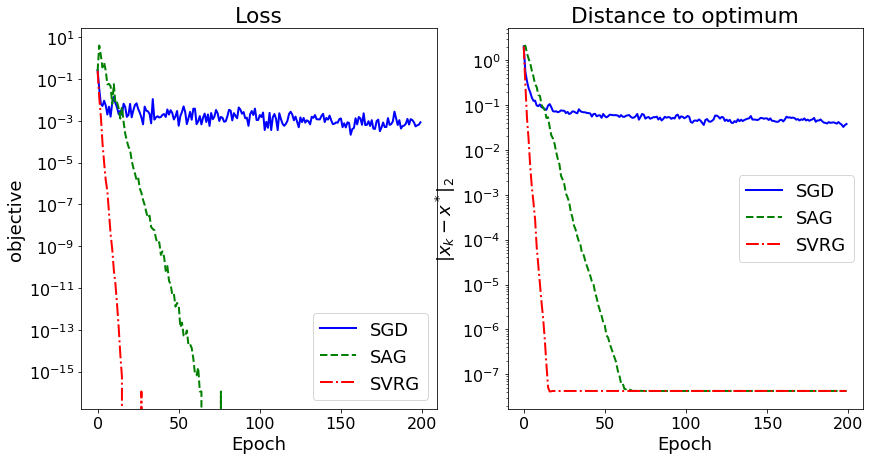

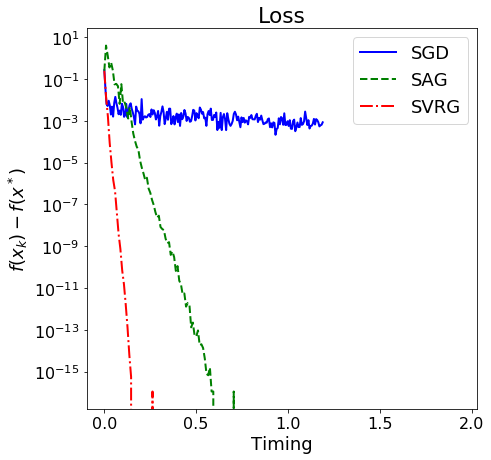

In [241]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]
solvers = ["SGD", "SAG", "SVRG"]
plot_epochs(monitors, solvers)
plot_time(monitors, solvers)

Clearly, SVRG performs much better than SAG adn SGD. SGD only do better than SAG in the intial several steps, however with iterartion numbers increasing, we see that SAG clearly outperform SGD. Moreover, both SVRG and SAG are heading towards the true values, while SGD hovers around some level after a number of interations and we observe obvious zigzag effect on SGD. 

<a id='comp'></a> 
## 5. Numerical comparison

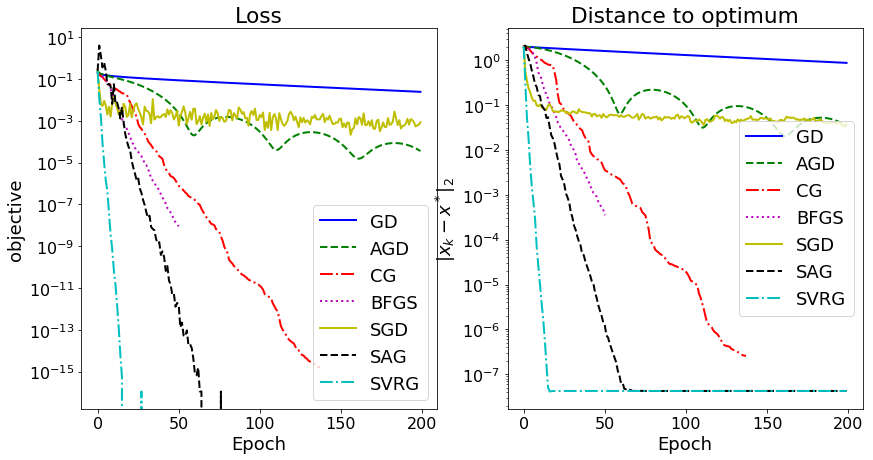

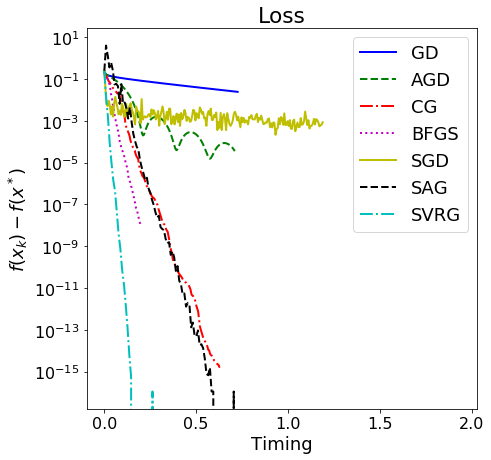

In [242]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]
plot_epochs(monitors, solvers)
plot_time(monitors, solvers)

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
####  Compare and comment your results


With a number of iteration euqal to 200, we could observe the following: 

We could observe that SVRG has the best performace with regard to convergence rate, also the best performance on time and it converges very fast to the true values.
When measuring by the number of iteration epochs, SAG looks to perform the second best, with BFGS the third, CG the fourth. These four method looks to be able to converge to the true values. 
However for methods, SGD, AGD and GD, it seems that they either converges to very slowly (GD) or they reach to a region close to the true value but hovers arond there and can not converges to the true values() around some level and can not converge to the true solution. Still, AGD looks to perform better than SGD and GD.

If we compare the time, still SVRG performs the best, BFGS the second, CG the third, SAG the foruth.  AGD performs bettwen than SGD and GD.  It seems that GD and SGD can not converges to the true values.  

SAG, SGD, AGD clearly are not monotonic, even overal the error is decreasing with the number of iterations increasing. 




#### Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.


In [243]:
# run all the methods

def run_all(method_list, A, b ,lbda):
    
    sol_ini_alg = method_list
    nr_solvers = len(sol_ini_alg)
    monitors_all = []
    for si in np.arange(nr_solvers):   
        monitor_si = monitor(sol_ini_alg[si], loss, x_min, (A, b ,lbda))

        if si < 2:  # i.e. si == 0: GD, and si == 1: AGD        
            step = 1. / lipschitz_linreg(A, b, lbda)      
            monitor_si.run(x_init, grad,  n_iter, step, args=(A, b, lbda))
        elif si == 2: # si == 2: CG   
            monitor_si.run(loss, x_init, grad,  maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)
        elif si == 3:  # si == 3: BFGS
            monitor_si.run(loss, x_init, grad,  maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)
        elif si >=4 and si < 6:   
            if si == 4: # si == 4: SGD
                step0 = 1e-1        
            elif si ==5 : # si == 5: SAG 
                step0 = 1.0 / (max_squared_sum + lbda)      
            monitor_si.run(x_init, iis, grad_i, n_iter*n,step0, args=(A, b, lbda))            
        elif si == 6: # SVRG
            step = 1.0 / (max_squared_sum + lbda) 
            monitor_si.run(x_init, iis, grad, grad_i, n_iter*n,step, args=(A, b, lbda))

        monitors_all.append(monitor_si)
    
    return monitors_all


In [244]:
# run all the model with lower ridges
lbda_low = 1. / n 
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda_low), pgtol=1e-30, factr=1e-30)
max_squared_sum = np.max(np.sum(A ** 2, axis=1))

sol_ini_alg = [gd, agd, scipy_runner(fmin_cg), scipy_runner(fmin_l_bfgs_b), sgd, sag, svrg]
monitors_lower = run_all(sol_ini_alg, A, b, lbda_low )



         Current function value: 0.501286
         Iterations: 189
         Function evaluations: 299
         Gradient evaluations: 298


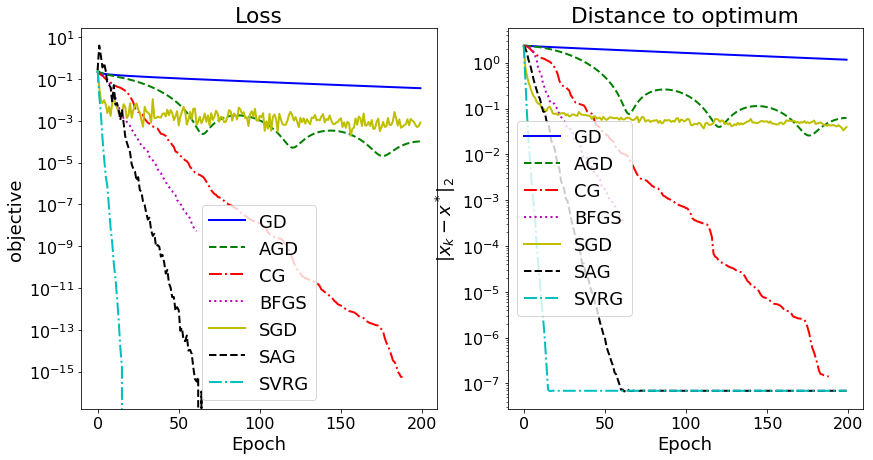

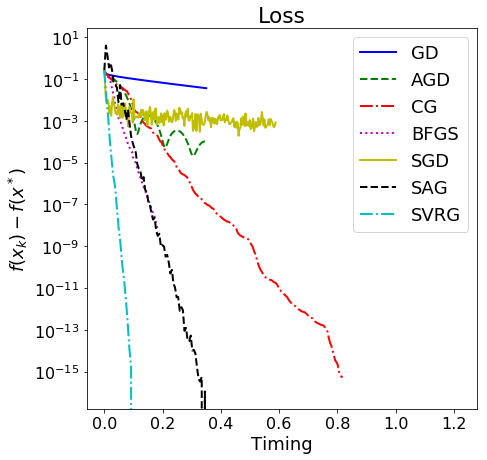

In [245]:
solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]
plot_epochs(monitors_lower, solvers)
plot_time(monitors_lower, solvers)

In [246]:
nr_m = len(sol_ini_alg)

monitor_time_high_ridge = []
# monitor_time_high_ridge = [monitor_gd.total_time, monitor_agd.total_time, monitor_cg.total_time, 
#          monitor_bfgs.total_time, monitor_sgd.total_time, monitor_sag.total_time, 
#          monitor_svrg.total_time]

print (nr_m)
monitor_time_low_ridge = []
for i in np.arange(nr_m):  
    monitor_time_low_ridge.append(monitors_lower[i].total_time)
    monitor_time_high_ridge.append(monitors[i].total_time)

pd.DataFrame({'Running time - low ridge' : monitor_time_low_ridge, 
              'Running time - high ridge' : monitor_time_high_ridge},
            solvers)

7


Running time - high ridge  Running time - low ridge
GD                     0.725916                  0.349921
AGD                    0.710409                  0.345358
CG                     0.630598                  0.818637
BFGS                   0.200799                  0.186656
SGD                    1.189043                  0.588153
SAG                    1.845003                  1.073609
SVRG                   1.933513                  1.219320

Both  Broyden-Fletcher-Goldfarb-Shanno (BFGS) and ConjugateGradients(CG) methods are Quasi-Newton Methods, which approximate the Hessian using recent function and gradient evaluations. Since the gradient of our objective function is a linear function of $\lambda: \nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x$. Therefore changing the magnitude of $\lambda$ does not influence the calculation time of $\nabla f_i(x)$ very much in each step. These two methods use the approximate gradients to come up with a new
search direction in which they do a combination of fixed-step, analytic-step and line-search minimizations. In the steps of finding a new search direction, $\lambda$ also does not affect the calculation time so much, therefore we see that the compuational time for CG and BFGS stays quite stable for two differet lambdas. 




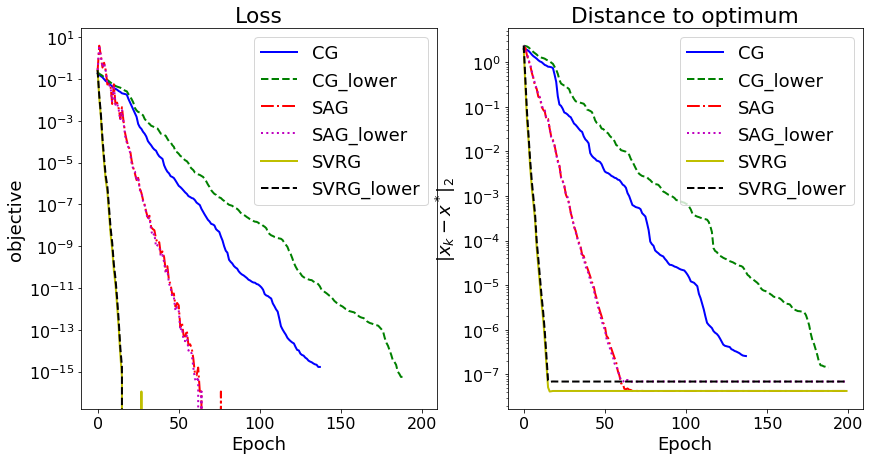

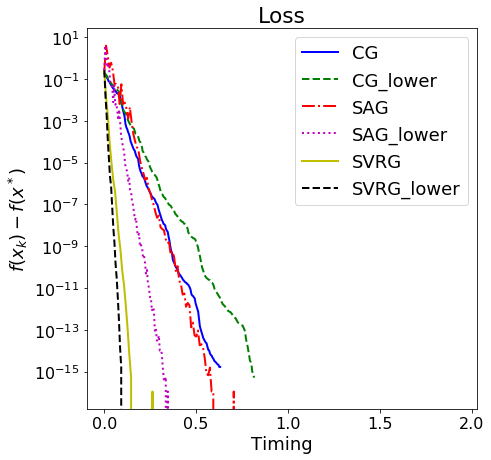

In [247]:
# compare SAG and CG with two different lbda values 
solvers_lambda = [ "CG", "CG_lower", "SAG", "SAG_lower","SVRG", "SVRG_lower",]
monitors_lambda = [monitors[2], monitors_lower[2], monitors[5], monitors_lower[5], monitors[6], monitors_lower[6]]
plot_epochs(monitors_lambda, solvers_lambda)
plot_time(monitors_lambda, solvers_lambda)



In [248]:
# print (monitors_lower[0].total_time, monitors_lower[1].total_time, monitors_lower[2].total_time)


In [249]:

# for monitor in monitors_lower:
#     print (monitor.total_time)
#     monitor_time_low_ridge.append(monitor.total_time)

We could see that the lbda parameter has a significant impact on the result. 
With respect to convergence rate, SVRG still performs the best, however, now BFGS the second, CG the third and they could still converges to the true values.  SAG, SGD, GD and AGD could not converges to the true values. 

With respect to the time,  SVRG performs the best, BFGS the second, and CG the third. 

The big difference happens with SAG. Before when lbda = 1/ (n ** 0.5), SAG performs well, only second to SVRG, however now, it does not even converge. Here we make a comparsion of SAG for the two different laba values, we also plot the case of CG for comparsion. 

As we could see, SAG method completely lost the convergence properties when the lbda_low = 1 / n, however the convergence rate of CG method does not change too much.

The explanation is that SAG is an average gradient method. Now lbda_low = 1 / n, the step is step = 1.0 / (max_squared_sum + lbda_low) becomes much higher. Since the step is much higher, a big step is applied to the update of x, and the gradient is calculated over all samples and taking average, the model could not find improvements after some iterations then due to the offsetting effect from the samples. 

#### Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.


In [250]:
correlations = [0.8, 0.95]
nr_corr = len(correlations)
lbda = 1. / n ** 0.5 
x_init = np.zeros(d)
sol_ini_alg = [gd, agd, scipy_runner(fmin_cg), scipy_runner(fmin_l_bfgs_b), sgd, sag, svrg]
monitors_all_corr = []

for ci in np.arange(nr_corr): 
    corri = correlations[ci]
    A, b = simu_linreg(x_model_truth, n, std=1., corr=corri)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)
    max_squared_sum = np.max(np.sum(A ** 2, axis=1))
    
    monitors_corri = run_all(sol_ini_alg, A, b, lbda)
    monitors_all_corr.append(monitors_corri)
    


         Current function value: 0.527683
         Iterations: 85
         Function evaluations: 145
         Gradient evaluations: 144
         Current function value: 0.523075
         Iterations: 197
         Function evaluations: 334
         Gradient evaluations: 333


we plot the case for correrlation = 0.8


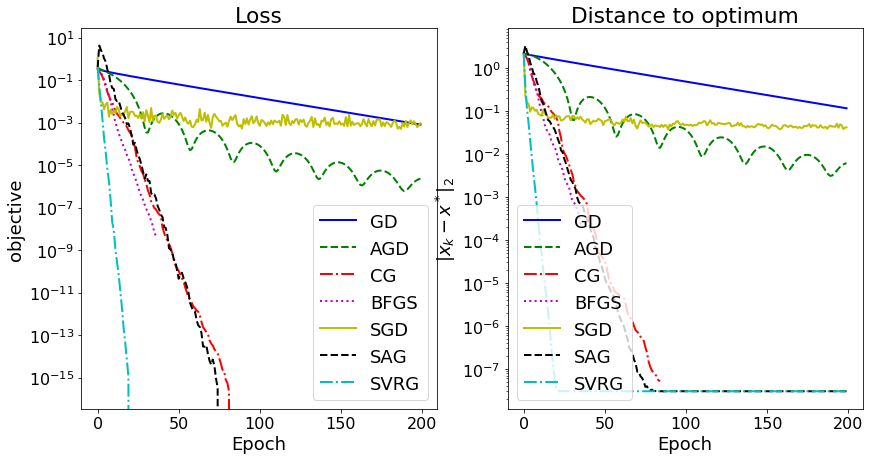

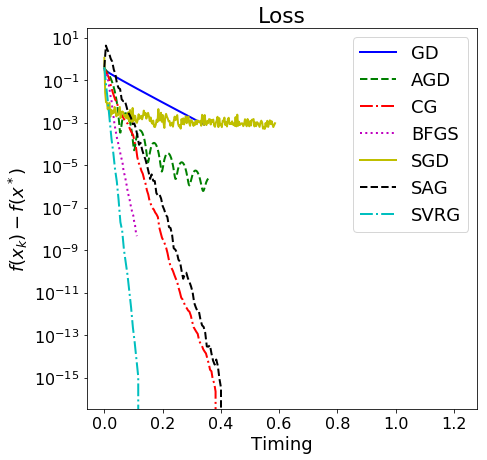

In [251]:
print ("we plot the case for correrlation = " + str(correlations[0]))
plot_epochs(monitors_all_corr[0], solvers)
plot_time(monitors_all_corr[0], solvers)



we plot the case for correrlation = 0.95


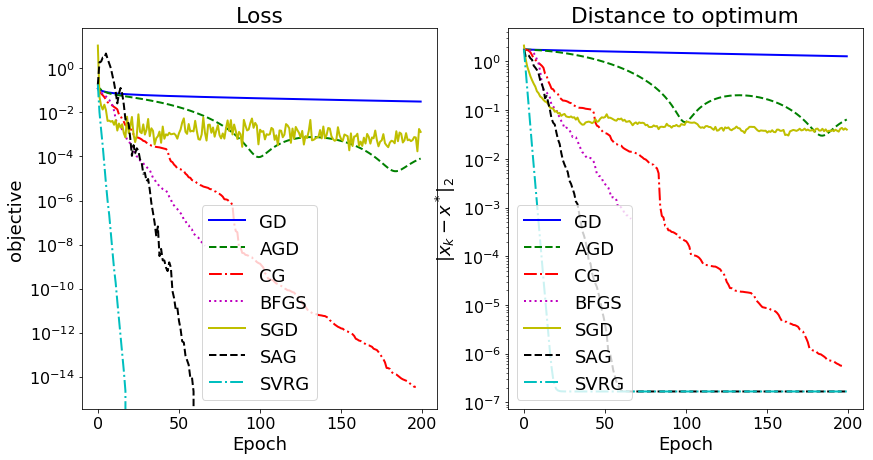

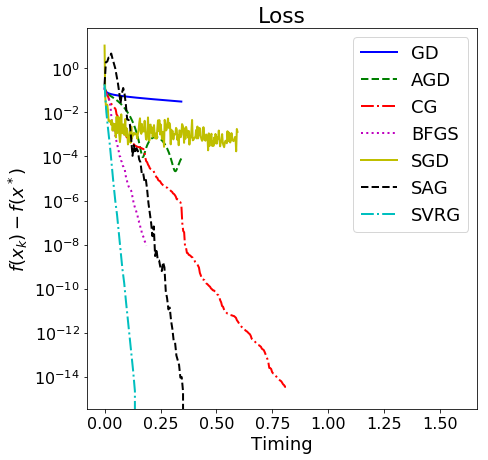

In [252]:
print ("we plot the case for correrlation = " + str(correlations[1]))
plot_epochs(monitors_all_corr[1], solvers)
plot_time(monitors_all_corr[1], solvers)


#### Comment on correlation 
We also try a correlation with 0.5, it turned out the model failed with a correlation samller than 0.6. Therefore, we will compare the difference with correlation as 0.75 and 0.96=5.


For a correlation 0.75, the SVRG, BFGS and CG methods still work well, and all other methods does not work at all, they simply blows up. 

For a correlation of 0.95, all the methods are somehow heading to the true value directions, with SVRG, BfGS and CG converges and the other methods stay close to but not reach the true values. 

Now we compare the three methods which converge for the two different correlation values. 



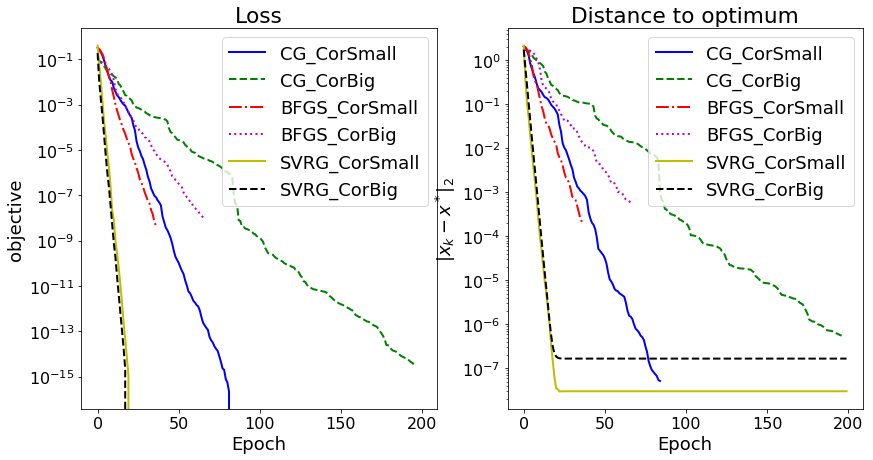

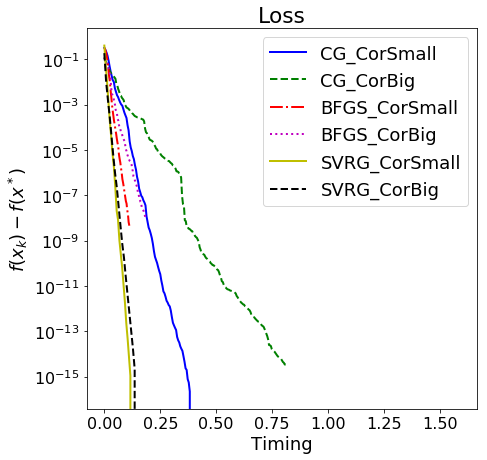

In [253]:
# compare SAG and CG with two different lbda values 
solvers_corr = [ "CG_CorSmall", "CG_CorBig", "BFGS_CorSmall", "BFGS_CorBig","SVRG_CorSmall", "SVRG_CorBig"]
monitors_corr = [monitors_all_corr[0][2], monitors_all_corr[1][2], monitors_all_corr[0][3],
               monitors_all_corr[1][3], monitors_all_corr[0][6], monitors_all_corr[1][6]]
plot_epochs(monitors_corr, solvers_corr)
plot_time(monitors_corr, solvers_corr)

####  Comment on correlation: 
We could clearly see that all method converges faster when the correlation is smaller. This is because when the correlations is higher, the matrix A condition number is bigger and then it takes more time to converge. 

However, the SVRG method is quite stable, almost not sensitive to the correlations. 


#### Conclude

 SVRG is a really efficient method. It is stable, and converge very fast!

## Still to do

Please review the comments, some are just description, I have not give explanation yet (not sure how). 
For the correlation case, some method failed for small correlations (e.g. 0.1), no idea why it happen, should double check. 

## all the comment code could be removed later when submmiting

In [254]:
# # run all the model with lower ridges
# lbda_low = 1. / n 
# x_init = np.zeros(d)
# x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda_low), pgtol=1e-30, factr=1e-30)

# n_iter = 300
# nr_solvers = len(solvers)
# max_squared_sum = np.max(np.sum(A ** 2, axis=1))

# sol_ini_alg = [gd, agd, scipy_runner(fmin_cg), scipy_runner(fmin_l_bfgs_b), sgd, sag, svrg]

# monitors_lower = []
# for si in np.arange(nr_solvers):   
#     monitor_si = monitor(sol_ini_alg[si], loss, x_min, (A, b ,lbda_low))
    
#     if si < 2:  # i.e. si == 0: GD, and si == 1: AGD        
#         step = 1. / lipschitz_linreg(A, b, lbda_low)      
#         monitor_si.run(x_init, grad,  n_iter, step, args=(A, b, lbda_low))
#     elif si == 2: # si == 2: CG   
#         monitor_si.run(loss, x_init, grad,  maxiter=n_iter, args=(A, b, lbda_low), gtol=1e-9)
#     elif si == 3:  # si == 3: BFGS
#         monitor_si.run(loss, x_init, grad,  maxiter=n_iter, args=(A, b, lbda_low), pgtol=1e-30)
#     elif si >=4 and si < 6:   
#         if si == 4: # si == 4: SGD
#             step0 = 1e-1        
#         elif si ==5 : # si == 5: SAG 
#             step0 = 1.0 / (max_squared_sum + lbda_low)      
#         monitor_si.run(x_init, iis, grad_i, n_iter*n,step0, args=(A, b, lbda_low))            
#     elif si == 6: # SVRG
#         step = 1.0 / (max_squared_sum + lbda_low) 
#         monitor_si.run(x_init, iis, grad, grad_i, n_iter*n,step, args=(A, b, lbda_low))
    
#     monitors_lower.append(monitor_si)
    

In [255]:
# #sol_loss = [loss, loss, loss, loss, loss, loss]
# #sol_xmin = [x_min, x_min, x_min, x_min, x_min, x_min]
# # sol_args = (A, b ,lbda)
# sol_run_

# # generate indices of random samples
# iis = np.random.randint(0, n, n * n_iter)
# monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
#             monitor_sgd, monitor_sag, monitor_svrg]

# solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]





# lbda = []


In [256]:
# # code : GD 

# n_iter = 50
# lbda = 1. / n ** (0.5)
# step = 1. / lipschitz_linreg(A, b, lbda)
# x_init = np.zeros(d)
# monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
# monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

# ###############
# # AGD
# step = 1. / lipschitz_linreg(A, b, lbda)
# x_init = np.zeros(d)
# monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
# monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

# ########################
# # CG
# x_init = np.zeros(d)
# monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A, b ,lbda))
# monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)
# ###################
# # BFGS

# from scipy.optimize import fmin_l_bfgs_b

# x_init = np.zeros(d)

# monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
# monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)
# ##################################
# # SGD
# step0 = 1e-1
# x_init = np.zeros(d)
# monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
# monitor_sgd.run(x_init, iis, grad_i, n_iter*n, step0, args=(A, b, lbda))
# #################
# ### SAG
# max_squared_sum = np.max(np.sum(A ** 2, axis=1))
# step = 1.0 / (max_squared_sum + lbda)
# x_init = np.zeros(d)
# monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
# monitor_sag.run(x_init, iis, grad_i, n_iter*n, step, args=(A, b, lbda))
# ######################################  
# ### SVRG

# x_init = np.zeros(d)
# monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
# monitor_svrg.run(x_init, iis, grad, grad_i, n_iter*n, step, args=(A, b, lbda))